In [ ]:
using Pkg
Pkg.add("Plots")
Pkg.add("Languages")
Pkg.add("DataFrames")
Pkg.add("CSV")
Pkg.add("Query")
Pkg.add("LightGraphs")
# conda install -c conda-forge flann 
# Pkg.add("SGtSNEpi")
Pkg.add("StatsBase")

# Lets see if we can identify duplicate or related projects

I.e. "Alberta" and "Government of Alberta" are the same thing.

In [2]:
using Languages
using DataFrames
using CSV
using Query
# using SparseArrays

df = CSV.read("../SAMPLE-ESTMA-data.csv", DataFrame)

eng_articles = articles(Languages.English())
eng_stops = stopwords(Languages.English())
simple_filter(x) = !(x in eng_stops || x in eng_articles)

simple_filter (generic function with 1 method)

In [3]:
ENV["COLUMNS"] = 400
first(df, 5)

,estma_id,entity,jurisdiction,period_start_date,period_end_date,reporting_cylce,country,payee_project_name,payee_or_project,payment_category,amount_reported_cad,web_Link,type_of_report,payment_notes
,String,String,String,String,String,Int64,String,String,String,String,String,String?,String,String?
1,E001568,Rochester Resources Ltd.,Canada,6/1/16,5/30/17,2016,Mexico,GENERAL MINING DIRECTION OF THE SECRETARIAT OF ECONOMY,payee,Fees,"217,444.04",https://www.dropbox.com/s/qh3p9uj615ryv4u/RCT - 2017.xlsx?dl=0,Individual Report,missing
2,E001568,Rochester Resources Ltd.,Canada,6/1/16,5/30/17,2016,Mexico,Government of Mexico,payee,Fees,"2,075.80",https://www.dropbox.com/s/qh3p9uj615ryv4u/RCT - 2017.xlsx?dl=0,Individual Report,Corporate tax instalments royalty payments WSIB premiums OMT payments and EHT payments.
3,E001568,Rochester Resources Ltd.,Canada,6/1/16,5/30/17,2016,Mexico,MEXICAN SOCIAL SECURITY INSTITUTE,payee,Taxes,"466,428.68",https://www.dropbox.com/s/qh3p9uj615ryv4u/RCT - 2017.xlsx?dl=0,Individual Report,missing
4,E001568,Rochester Resources Ltd.,Canada,6/1/16,5/30/17,2016,Mexico,Estanzuela,project,Fees,"49,299.97",https://www.dropbox.com/s/qh3p9uj615ryv4u/RCT - 2017.xlsx?dl=0,Individual Report,Royalties - Includes $208 236 of paid-in-kind royalties valued at realized prices
5,E001568,Rochester Resources Ltd.,Canada,6/1/16,5/30/17,2016,Mexico,Estanzuela,project,Taxes,"348,070.57",https://www.dropbox.com/s/qh3p9uj615ryv4u/RCT - 2017.xlsx?dl=0,Individual Report,Alberta Boiler Association Alberta Energy Alberta Energy Regulator Alberta Petroleum & Marketing Commission Bonuses - Alberta Land Sale Auction Royalties - Includes $611 292 of paid-in-kind royalties valued at realized prices


In [4]:
payees_or_projects = unique(df.payee_project_name)

8132-element Vector{String}:
 "GENERAL MINING DIRECTION OF THE SECRETARIAT OF ECONOMY"
 "Government of Mexico"
 "MEXICAN SOCIAL SECURITY INSTITUTE"
 "Estanzuela"
 "San Fransisco"
 "Santa Fe"
 "STATE OF NAYARIT"
 "San Francisco"
 "Quebec City Quebec"
 "Qiqavik"
 "West Raglan"
 "City of Ulaanbaatar"
 "Gobi Oyu Development Support Fund"
 ⋮
 "Province of Chumbivilcas"
 "Town of Creighton"
 "Town of Snow Lake"
 "Constancia"
 "Rosemont"
 "Municipal District of Condoroma"
 "Municipal District of Coporaque"
 "Arizona State Government"
 "National Government of Chile"
 "Pima/Santa Cruz County Government"
 "Provincial Government of Manitoba"
 "United States of America Army Corps"

In [5]:
# Vectorize and remove articles
vectorized_names = payees_or_projects .|> 
        lowercase .|> 
        split .|> 
        (x -> filter(simple_filter, x)) |> unique

7961-element Vector{Vector{SubString{String}}}:
 ["mining", "direction", "secretariat", "economy"]
 ["government", "mexico"]
 ["mexican", "social", "security", "institute"]
 ["estanzuela"]
 ["san", "fransisco"]
 ["santa", "fe"]
 ["nayarit"]
 ["san", "francisco"]
 ["quebec", "city", "quebec"]
 ["qiqavik"]
 ["west", "raglan"]
 ["city", "ulaanbaatar"]
 ["gobi", "oyu", "development", "support", "fund"]
 ⋮
 ["province", "chumbivilcas"]
 ["town", "creighton"]
 ["town", "snow", "lake"]
 ["constancia"]
 ["rosemont"]
 ["municipal", "district", "condoroma"]
 ["municipal", "district", "coporaque"]
 ["arizona", "government"]
 ["national", "government", "chile"]
 ["pima/santa", "cruz", "county", "government"]
 ["provincial", "government", "manitoba"]
 ["united", "america", "army", "corps"]

In [155]:
inverse_vectorized(x) = [
    y for y in payees_or_projects
        if x == filter(simple_filter, split(lowercase(y)))
]

inverse_vectorized (generic function with 1 method)

### Note: already identified 200 likely duplicates here after removing articles and lowercasing

In [100]:
duplicates = let
    tmp = payees_or_projects .|> 
            lowercase .|> 
            split .|> 
            (x -> filter(simple_filter, x))
    
    dups = filter(x -> last(x) > 1, countmap(tmp)) |>
                keys .|>
                x -> findall(isequal(x), tmp)
    
    dups = collect(Iterators.flatten(dups))

    getindex(payees_or_projects, dups)
end
    

326-element Vector{String}:
 "Regional Municipality of Wood Buffalo"
 "The Regional Municipality of Wood Buffalo"
 "Department of Interior"
 "US Department of the Interior"
 "Government of Zacatecas"
 "State Government of Zacatecas"
 "Municipality of Puerto Gaitan"
 "Municipality Puerto Gaitan"
 "Greater Laggan Area"
 "Greater  Laggan Area"
 "State of Texas"
 "State Texas"
 "Texas"
 ⋮
 "The Province of Saskatchewan"
 "Government of Northern Territory"
 "Government of the Northern Territory"
 "Exploration"
 "General Exploration"
 "Minister of Finance Province of British Columbia"
 "MINISTER OF FINANCE PROVINCE OF BRITISH COLUMBIA"
 "State of Zacatecas"
 "The State of Zacatecas"
 "Zacatecas"
 "State of Nevada"
 "The State of Nevada"

# 326 duplicates found, lets keep going

In [6]:
# Count the common number of words
counts(a, b) = length(intersect(a,b))

counts (generic function with 1 method)

In [7]:
@time begin

width = length(vectorized_names)

m = zeros(Int64, (width, width))

# Symmetric matrix and skip the diagonal
# Still 32000000 entries!!!
for i in 1:width
    for j in (i+1):width
        val = counts(vectorized_names[i], vectorized_names[j])
        val == 0 && continue # skip array allocation if no overlap
        m[i,j] = m[j,i] = val
    end
end
# [counts(a,b) for a in vectorized_names, b in vectorized_names]

end

 93.527065 seconds (507.28 M allocations: 54.158 GiB, 15.76% gc time, 0.18% compilation time)


In [8]:
m

7961×7961 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0 

In [27]:
# Are there any with no neighbors?
count = 0
for i in 1:width
    if max(m[:,1]...) == 0
        count += 1
    end
end

In [29]:
count

0

## Very high connectivity!

All the rows are connected to at least one neighbour. Let's see how many neighbours

In [34]:
adjacent(i) = findall(m[:,i] .> 0)

adjacent (generic function with 1 method)

In [35]:
getindex(vectorized_names, findall(m[:,1] .> 0))

64-element Vector{Vector{SubString{String}}}:
 ["national", "department", "mining", "produtction"]
 ["saskatchewan", "mining", "assoc."]
 ["saskatchewan", "ministry", "economy"]
 ["oil", "sands", "mining", "upgrading"]
 ["secretary", "economy"]
 ["jurisdictional", "mining", "administrative", "authority"]
 ["bolivian", "jurisdictional", "mining", "administrative", "authority"]
 ["bisha", "mine", "(bisha", "mining", "share", "company)"]
 ["eritrean", "national", "mining", "company", "(enamco)"]
 ["mining", "donation", "equipment/transportation", "electrical", "poles"]
 ["ssr", "mining", "-", "corporate"]
 ["saskatchewan", "mining", "association"]
 ["bathurst", "mining", "camp"]
 ⋮
 ["mcmahon", "mining", "title", "services"]
 ["mining", "title", "services"]
 ["ministry", "economy", "labour", "transport", "lower", "saxony"]
 ["wolfram", "camp", "mining", "pty", "limited"]
 ["minstry", "economy", "regina", "saskatchewan"]
 ["guanajuato", "mining", "complex"]
 ["banro", "congo", "mining", "s

In [33]:
vectorized_names[1]

4-element Vector{SubString{String}}:
 "mining"
 "direction"
 "secretariat"
 "economy"

### Ahah! It's a few words (in this case "mining") which are super prevalent.

Let's plot a histogram of the terms, and remove some big ones to make this graph sparser. Like an ad-hoc [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In [42]:
using Plots
using StatsBase

In [40]:
all_words = collect(Iterators.flatten(vectorized_names))

22007-element Vector{SubString{String}}:
 "mining"
 "direction"
 "secretariat"
 "economy"
 "government"
 "mexico"
 "mexican"
 "social"
 "security"
 "institute"
 "estanzuela"
 "san"
 "fransisco"
 ⋮
 "chile"
 "pima/santa"
 "cruz"
 "county"
 "government"
 "provincial"
 "government"
 "manitoba"
 "united"
 "america"
 "army"
 "corps"

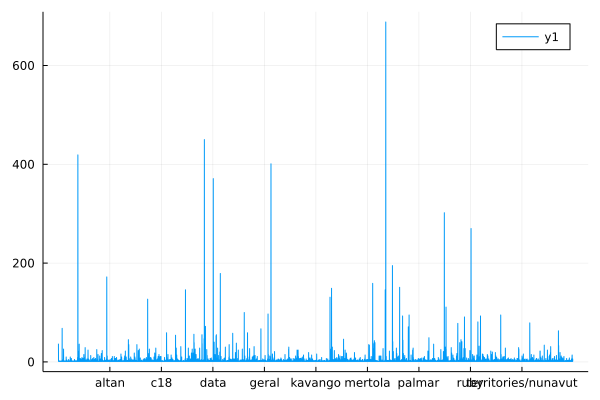

In [113]:
plot(countmap(all_words))

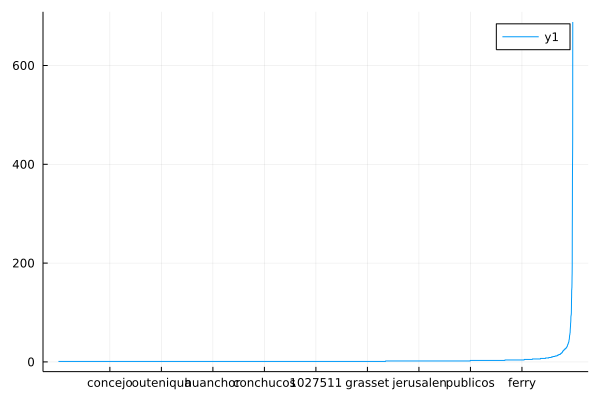

In [112]:
sorted_counts = sort(collect(countmap(all_words)), by=last)

our_words = sorted_counts .|> first
our_counts = sorted_counts .|> last

plot(our_words, our_counts)

### A few very common words

This makes sense! Lets see what they are

In [44]:
word_counts = countmap(all_words)

Dict{SubString{String}, Int64} with 6641 entries:
  "indra"             => 1
  "khanh)"            => 1
  "occitans"          => 1
  "guysborough"       => 3
  "princess"          => 2
  "clamidad"          => 1
  "libertad"          => 4
  "g-cs-02"           => 1
  "ripsey"            => 1
  "135-136"           => 1
  "asturias"          => 4
  "nouveau-brunswick" => 1
  "veta"              => 2
  "henry"             => 2
  "matimekush"        => 1
  "borders"           => 3
  "cubatao"           => 1
  "corihuarmi"        => 1
  "canyon"            => 15
  "star"              => 4
  "kennedale"         => 1
  "ventures"          => 6
  "05"                => 2
  "huaral"            => 2
  "plan"              => 1
  ⋮                   => ⋮

In [49]:
filter(x -> last(x) > 100, word_counts)

Dict{SubString{String}, Int64} with 18 entries:
  "county"       => 450
  "municipal"    => 146
  "nation"       => 195
  "government"   => 401
  "district"     => 179
  "municipality" => 688
  "alberta"      => 172
  "lake"         => 149
  "block"        => 127
  "mine"         => 159
  "no."          => 151
  "rural"        => 270
  "de"           => 371
  "la"           => 131
  "project"      => 302
  "province"     => 111
  "-"            => 419
  "city"         => 146

### Great! We can remove some of these.

Some have semantic meaning (e.g. Alberta), but others, `-` or `municipal`, for instance, do not really contribute too much. We will filter them out and we should be left with a much sparser graph.

In [70]:
removable = filter(x -> last(x) > 100, word_counts) |> keys |> collect

# Only alberta seems important in this list
deleteat!(removable, removable .== "alberta")

17-element Vector{SubString{String}}:
 "county"
 "municipal"
 "nation"
 "government"
 "district"
 "municipality"
 "lake"
 "block"
 "mine"
 "no."
 "rural"
 "de"
 "la"
 "project"
 "province"
 "-"
 "city"

In [86]:
filtered_vectorized_names = vectorized_names .|> 
    (y -> filter(x -> !(x in removable), y)) 

7961-element Vector{Vector{SubString{String}}}:
 ["mining", "direction", "secretariat", "economy"]
 ["mexico"]
 ["mexican", "social", "security", "institute"]
 ["estanzuela"]
 ["san", "fransisco"]
 ["santa", "fe"]
 ["nayarit"]
 ["san", "francisco"]
 ["quebec", "quebec"]
 ["qiqavik"]
 ["west", "raglan"]
 ["ulaanbaatar"]
 ["gobi", "oyu", "development", "support", "fund"]
 ⋮
 ["chumbivilcas"]
 ["town", "creighton"]
 ["town", "snow"]
 ["constancia"]
 ["rosemont"]
 ["condoroma"]
 ["coporaque"]
 ["arizona"]
 ["national", "chile"]
 ["pima/santa", "cruz"]
 ["provincial", "manitoba"]
 ["united", "america", "army", "corps"]

### As we did before, lets identify if any duplicated have appeared

In [127]:
length(filtered_vectorized_names) - length(unique(filtered_vectorized_names))

603

#### 600 duplicates!!

In [156]:
more_duplicates = let
    dups = filter(x -> last(x) > 1, countmap(filtered_vectorized_names)) |> keys
    indexes = dups .|> (x -> findall(isequal(x), filtered_vectorized_names))
    orig_vals = indexes .|> (x -> getindex(vectorized_names, x))
    orig_vals .|> (x -> x .|> inverse_vectorized)
end

503-element Vector{Vector{Vector{String}}}:
 [["County of Red Deer Alberta"], ["Red Deer  Alberta"]]
 [["Eagle Lake First Nation"], ["Eagle"]]
 [["County of Mountainview"], ["Mountainview County"]]
 [["Coffee"], ["Coffee Project"]]
 [["Queensland Office of State Revenue"], ["Queensland Government Office of State Revenue"]]
 [["Red Deer County"], ["County of Red Deer"], ["Red Deer"]]
 [["RURAL MUNICIPALITY OF ANTELOPE PARK NO. 322"], ["RURAL MUNICIPALITY OF ANTELOPE PARK NO 322"]]
 [["MUNICIPAL DISTRICT OF ROCKYVIEW"], ["Rockyview County"], ["County of Rockyview"]]
 [["Lima"], ["District of Lima"], ["Province of Lima"]]
 [["Government of France"], ["France"]]
 [["C18"], ["Block C18"]]
 [["Selenge Province"], ["Province of Selenge"]]
 [["Block 10bb"], ["10bb"]]
 ⋮
 [["Municipality of Belo Horizonte"], ["City of Belo Horizonte"]]
 [["San Luis"], ["San Luis Project"]]
 [["City of Brooks"], ["Brooks"]]
 [["MUNICIPAL DISTRICT OF BIGHORN"], ["Bighorn"]]
 [["Central"], ["Central District"]]
 [

## Let's keep going

In [157]:
filtered_vectorized_names = unique(filtered_vectorized_names)

7358-element Vector{Vector{SubString{String}}}:
 ["mining", "direction", "secretariat", "economy"]
 ["mexico"]
 ["mexican", "social", "security", "institute"]
 ["estanzuela"]
 ["san", "fransisco"]
 ["santa", "fe"]
 ["nayarit"]
 ["san", "francisco"]
 ["quebec", "quebec"]
 ["qiqavik"]
 ["west", "raglan"]
 ["ulaanbaatar"]
 ["gobi", "oyu", "development", "support", "fund"]
 ⋮
 ["livitaca"]
 ["velille"]
 ["chumbivilcas"]
 ["town", "creighton"]
 ["town", "snow"]
 ["constancia"]
 ["rosemont"]
 ["coporaque"]
 ["national", "chile"]
 ["pima/santa", "cruz"]
 ["provincial", "manitoba"]
 ["united", "america", "army", "corps"]

In [158]:
@time begin

width = length(filtered_vectorized_names)

m = zeros(Int64, (width, width))

# Symmetric matrix and skip the diagonal
# Still 32000000 entries!!!
for i in 1:width
    for j in (i+1):width
        val = counts(filtered_vectorized_names[i], filtered_vectorized_names[j])
        val == 0 && continue # skip array allocation if no overlap
        m[i,j] = m[j,i] = val
    end
end
# [counts(a,b) for a in vectorized_names, b in vectorized_names]

end

 51.983987 seconds (432.93 M allocations: 45.873 GiB, 22.73% gc time)


In [88]:
m

7961×7961 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0 

In [89]:
# Are there any with no neighbors?
count = 0
for i in 1:width
    if max(m[:,1]...) == 0
        count += 1
    end
end

In [90]:
count

0

In [92]:
adjacent(i) = findall(m[:,i] .> 0)
getindex(filtered_vectorized_names, adjacent(6))

31-element Vector{Vector{SubString{String}}}:
 ["santa", "anita"]
 ["santa", "luz", "desenvolvimento"]
 ["santa", "catarina"]
 ["santa", "cruz"]
 ["santa", "elena"]
 ["santa", "cruz", "sierra"]
 ["department", "santa", "cruz"]
 ["santa", "ana"]
 ["santa", "cruz", "del", "norte"]
 ["santa", "fe", "antioquia"]
 ["santa", "fe", "antioquia"]
 ["santa", "elena", "silver/gold"]
 ["santa", "elena", "silver", "gold"]
 ⋮
 ["comunidad", "nativa", "santa", "rosa"]
 ["santa", "victoria"]
 ["santa", "renia"]
 ["santa", "cruz"]
 ["santa", "rita", "virginia"]
 ["santa", "helena"]
 ["colla", "community", "santa", "rosa"]
 ["santa", "lucia"]
 ["santa", "barbara"]
 ["department", "interior", "-bureau", "land", "management", "santa", "fe", "mexico"]
 ["comunidad", "campesina", "santa", "cruz", "andamarca"]
 ["santa", "rosa"]

In [125]:
length(filter(x -> last(x) < 50, word_counts))

6598

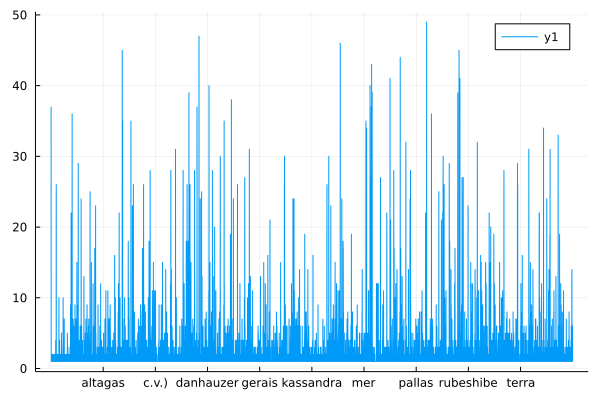

In [126]:
plot(filter(x -> last(x) < 50, word_counts))

In [118]:
sum(m) / length(m)

0.0008442425509195918